<a href="https://colab.research.google.com/github/khalyl-hamdy/mission/blob/main/Mission_TA_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Talan Academy Mission:**
In this example will discover an implimentation for Deep Learning Algorithms. In fact, we will focus on the Natural Language Processing (NLP) where we are going to build a model that predicts the category of an article (Politics,Business,Sport...) using only its title or part of its body.


>Definition: Natural language processing (NLP) is a field within artificial intelligence (AI) and machine learning that combines linguistics and computer science to break down language, so it can be analyzed by machines.Natural language processing (NLP) is a field within artificial intelligence (AI) and machine learning that combines linguistics and computer science to break down language, so it can be analyzed by machines.








## Step 1: Google Colab and import libraries
What is Colaboratory?

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with: 
- Zero configuration required
- Free access to GPUs
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier.

###Using Google Drive to aget access to colab 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/NLP/text_classification


/content/gdrive/My Drive/NLP/text_classification


### Import Labraries : numpy, pandas, matplotlib, Keras, sklearn.

In [4]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)


from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split


## Step 2: Load Data, Get an overview and Apply changes

Load the json file into pandas Dataframe and display it.

In [5]:
# load data

df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


Get an overview: 

In [48]:
print ("Data Size = ", df.size)

Data Size =  1999140


In [7]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

### Processing:
Create new column "text" which concatinates the title and the description of an article (input data for the model).

Then use Tokenizer to vectorize the text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) 

Delete null or short text rows in order to get better results

In [9]:
# using headlines and short_description as input X
df['text'] = df.headline + " " + df.short_description

#Same category with two differnt names:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

# tokenizing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df.head()

,category,headline,authors,link,short_description,date,text,words,word_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26


Word padding .

Create dict that maps each category with an integer.

In [10]:
# using 50 for padding length

maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

In [11]:
# category to id

categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
print (len (int_category))
print (int_category[16])
print (int_category[3])

40
HEALTHY LIVING
BUSINESS


In [18]:
df.head()

,category,headline,authors,link,short_description,date,text,words,word_length,c2id
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[74, 101, 257, 1331, 3001, 6, 698, 134, 96, 26...",27,6
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, ...",20,10
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[5877, 5334, 8083, 8, 1, 76, 54, 21, 414, 8469...",25,10
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[2710, 13374, 3596, 64143, 2295, 13055, 5, 569...",26,10
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[41003, 36082, 1513, 97, 48, 7915, 3134, 2, 96...",26,10


In [52]:
print ("Example of text and its vector:")
print (df['text'][1])
print (df['words'][1])

Example of text and its vector
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song.
[42, 1604, 2960, 27762, 5, 25929, 5237, 8, 1, 2573, 80, 36081, 971, 1002, 4, 533, 14, 38, 3, 1002]



### glove embedding
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. ( using trained model)


In [20]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100
### Link to download glove.6b.100d.txt file : https://drive.google.com/file/d/1IVUueXEEDsEEVktMJUm7U5xhSClMgCLv/view?usp=sharing
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 116617 unique tokens.
Total 400000 word vectors.


In [21]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

### split dataset
Split data into training and testing sets where the training set is 70% of the original data and the testing set is 30%.

In [22]:
# prepared data 

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=seed)

## Step 3: Build and train the model


In [23]:
#build
inp = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))(x)
x = Conv1D(64, kernel_size=3)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
outp = Dense(len(int_category), activation="softmax")(x)

BiGRU = Model(inp, outp)
BiGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

BiGRU.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      11661800    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 50, 100)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 256)      176640      spatial_dropout1d[0][0]          
_______________________________________________________________________________________

In [37]:
# training

bigru_history = BiGRU.fit(x_train, 
                          y_train, 
                          batch_size=1024, 
                          epochs=8, 
                          validation_data=(x_val, y_val))


Epoch 1/8
137/137 [==============================] - 43s 311ms/step - loss: 1.3164 - acc: 0.6170 - val_loss: 1.2854 - val_acc: 0.6276
Epoch 2/8
137/137 [==============================] - 43s 313ms/step - loss: 1.3104 - acc: 0.6191 - val_loss: 1.2773 - val_acc: 0.6292
Epoch 3/8
137/137 [==============================] - 42s 310ms/step - loss: 1.3059 - acc: 0.6211 - val_loss: 1.2743 - val_acc: 0.6302
Epoch 4/8
137/137 [==============================] - 42s 309ms/step - loss: 1.2950 - acc: 0.6227 - val_loss: 1.2691 - val_acc: 0.6306
Epoch 5/8
137/137 [==============================] - 43s 311ms/step - loss: 1.2889 - acc: 0.6242 - val_loss: 1.2693 - val_acc: 0.6308
Epoch 6/8
137/137 [==============================] - 43s 312ms/step - loss: 1.2841 - acc: 0.6259 - val_loss: 1.2712 - val_acc: 0.6316
Epoch 7/8
137/137 [==============================] - 43s 313ms/step - loss: 1.2803 - acc: 0.6257 - val_loss: 1.2639 - val_acc: 0.6326
Epoch 8/8
137/137 [==============================] - 44s 319ms

## Step 4: Evaluation and Prection:

We will display :

- The training and validation accuracy plot 
- The training and validation loss plot


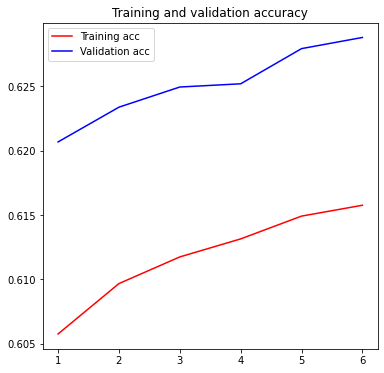

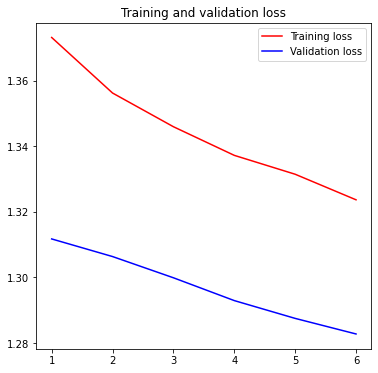

In [27]:
acc = bigru_history.history['acc']
val_acc =bigru_history.history['val_acc']
loss = bigru_history.history['loss']
val_loss = bigru_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

Evaluate the model on the validation set and calculate the total accuracy rate.

In [30]:
def evaluate_accuracy(model):
    predicted = model.predict(x_val)
    diff = y_val.argmax(axis=-1) - predicted.argmax(axis=-1)
    corrects = np.where(diff == 0)[0].shape[0]
    total = y_val.shape[0]
    return float(corrects/total)

In [55]:
print("model Accuracy:       %.6f" % evaluate_accuracy(BiGRU))

model Accuracy:       0.634664


### The process of prediction contains 4 main step:
- Use tokenizer to vectorize the new text.
- Use words padding to convert the new text vector into the input size vector.
- Use the model to predict the category nummber.
- Map the category number with the category name.

In [58]:
#txt='War, in the popular sense, a conflict between political groups involving hostilities of considerable duration and magnitude. In the usage of social science, certain qualifications are added. Sociologists usually apply the term to such conflicts only if they are initiated and conducted in accordance with socially recognized forms. They treat war as an institution recognized in custom or in law. Military writers usually confine the term to hostilities in which the contending groups are sufficiently equal in power to render the outcome uncertain for a time. Armed conflicts of powerful states with isolated and powerless peoples are usually called pacifications, military expeditions, or explorations; with small states, they are called interventions or reprisals; and with internal groups, rebellions or insurrections. Such incidents, if the resistance is sufficiently strong or protracted, may achieve a magnitude that entitles them to the name “war.”'
#txt='Automotive plant closures may be linked with a rise in opioid overdose deaths, new study says'
#txt='These were the 5 biggest days for the stock market this year'
#txt="Snapchat unveils redesigned Spectacles sunglasses with hefty price tag"
#txt="The overhaul of the federal tax law in 2017 was the signature legislative achievement of Donald J. Trump’s presidency. The biggest change to the tax code in three decades, the law slashed taxes for big companies, part of an effort to coax them to invest more in the United States and to discourage them from stashing profits in overseas tax havens. Corporate executives, major investors and the wealthiest Americans hailed the tax cuts as a once-in-a-generation boon not only to their own fortunes but also to the United States economy."
#txt="ZLANTA CLAUS Zlatan Ibrahimovic celebrates PS5 launch day by giving AC Milan team-mates in-demand new console"
txt="Football is the most popular sport in Tunisia. The Tunisia national football team, also known as The Eagles of Carthage, won the 2004 African Cup of Nations (CAN) which was held in Tunisia.[8] They also represented Africa in the 2005 Confederations Cup which was held in Germany, but they could not go beyond the first round. The Eagles of Carthage have participated in four FIFA World Cup Championships."

seq= tokenizer.texts_to_sequences([txt])
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = BiGRU.predict(padded)
categ_res=int_category[pred.argmax(axis=1)[0]]
print (categ_res)

SPORTS


## Step 5: Save Model, Tokenizer and int_category dictionary

You can save the model and load if you want to use it again and avoid the training proces

- Save the model h5 fil.
- Save Tokenizer in pickle file.
- Saveint_category dictionary in pickle file.

In [ ]:
#how to ave the model
BiGRU.save('model/Model_BiGRU.h5') 
#how to load a model
model = load_model('Model_GRU.h5')

In [ ]:
import pickle          ##library to save and load pickle file
#Save tokinzer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
#Load Tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [ ]:
#Save int_category dict
with open('int_category.pickle', 'wb') as handle:
    pickle.dump(int_category, handle, protocol=pickle.HIGHEST_PROTOCOL)
#Load int_category dict
with open('int_category.pickle', 'rb') as handle:
    int_category = pickle.load(handle)